In [224]:
#importing all necessary libraries
import os,sys,platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch as torch
import torch.nn as nn
import seaborn as sb
import sklearn as sk
from copy import deepcopy as copy

#for decision tree
from sklearn import tree
from sklearn.preprocessing import LabelEncoder, TargetEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score as auc
from sklearn.metrics import confusion_matrix as cm
from sklearn.model_selection import train_test_split

#Tools for data processing
from sklearn.model_selection import train_test_split
from sklearn.utils import validation, parallel
from sklearn.preprocessing import MinMaxScaler,StandardScaler


#Tools for model evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay as showMatrix # for Classification

from IPython.display import Image

from torch.utils.data import DataLoader
from torch.nn import functional as F # for efficiency

from torchvision.transforms import ToTensor

In [225]:
#confirm and checking platform and sotware versions in software stack
print(f"Python Platform:{platform.platform()}")
print(f"Python {sys.version}")
print(f"PyTorch Version: ", torch.__version__)
print(f"Pandas Version: " , pd.__version__)
print(f"SkLearn Version: " , sk. __version__)

Python Platform:macOS-14.0-arm64-arm-64bit
Python 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:41:52) [Clang 15.0.7 ]
PyTorch Version:  2.1.1
Pandas Version:  2.1.4
SkLearn Version:  1.3.0


In [226]:
#checking devices available,though I know this is unfortunately not usable here, I always include it in my code 
#So I can know what the run can "see"

available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
# print the names
for i in available_gpus:
    print(torch.cuda.get_device_properties(i).name)

# Prints 'Tesla V100-SXM2-16GB', for example
print(torch.version.cuda)
device = torch.device('cuda' if torch.cuda.is_available() or torch.backends.mps.is_available() else 'cpu')
print("Using device: ", device)

None
Using device:  cuda


In [227]:
#Make sure we're pointing at the right directory in relation to where we are.
print(os.getcwd())

#Import data and separate out
whitewinedataraw = pd.read_csv("winequality-white.csv",sep=';')
redwinedataraw = pd.read_csv("winequality-red.csv", sep=';')

#view raw data, get info about it, clean if necessary
whitewinedataraw.info() #information about range
whitewinedataraw.describe() #Description of features
whitewinedataraw.duplicated() #Do we have any duplicate values in our data?
cat_col = [col for col in whitewinedata.columns if whitewinedata[col].dtype=='object']
num_col = [col for col in whitewinedata.columns if whitewinedata[col].dtype!='object']
print("Categorical columns: ", cat_col)
print("Numerical columns: ", num_col)

redwinedataraw.info()
redwinedataraw.describe()
redwinedataraw.duplicated()
cat_col = [col for col in redwinedataraw.columns if redwinedataraw[col].dtype=='object']
num_col = [col for col in redwinedataraw.columns if redwinedataraw[col].dtype!='object']
print("Categorical columns: ", cat_col)
print("Numerical columns: ", num_col)

/Users/lisa/Documents/GitHub/exploratory-data-anlysis-lrstafford
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB
Categorical columns:  []
Numerical columns:  ['fixed acidity'

In [228]:
whitewinedata = whitewinedataraw.copy()
whitewinelabels = whitewinedata.pop('quality')
display(whitewinelabels)

0       6
1       6
2       6
3       6
4       6
       ..
4893    6
4894    5
4895    6
4896    7
4897    6
Name: quality, Length: 4898, dtype: int64

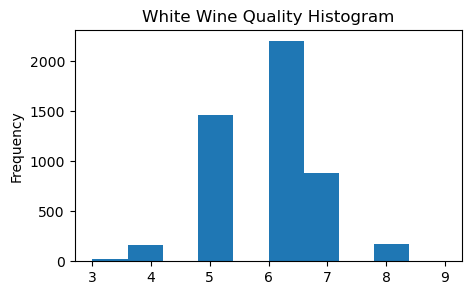

In [229]:
#Show a histogram of the distribution of label data
plot = whitewinelabels.plot(kind='hist', title="White Wine Quality Histogram", figsize=(5,3))

In [230]:
redwinedata = redwinedataraw.copy()
redwinelabels = redwinedata.pop('quality')
display(redwinelabels)

0       5
1       5
2       5
3       6
4       5
       ..
1594    5
1595    6
1596    6
1597    5
1598    6
Name: quality, Length: 1599, dtype: int64

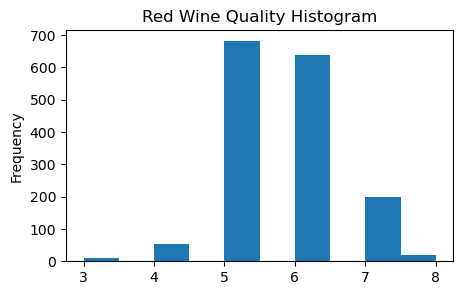

In [231]:
#Show a histogram of the distribution of label data
plot = redwinelabels.plot(kind='hist', title="Red Wine Quality Histogram", figsize=(5,3))

## Exploratory Data Analysis:  
We will attempt to analyze and summarize each dataset, identifying characteristics, patterns and relationships within the data prior to applying any sort machine learning techniques.

### MetaInformation

Prior to performing any analysis on the data we can reference the data repository metadata and data analysis. 

#### Wine Data
Our wine dataset obtained from https://archive.ics.uci.edu/dataset/186/wine+quality provides some information on the data.  

"Two datasets are [provided] related to red and white variants of...wine.  [Additionally] ..."the classes are ordered and [unbalanced] so there are many more normal wines than excellent or poor ones." Both datasets have 11 physiochemical features, no missing values, and a sensory output label ('quality').      

The white wine dataset consists of 4898 total wines while the red wine dataset consists of 1599 total wines.  Data features are consistent with non-null and non-uninterpretable data for both the red and white datasets.  




In [232]:
#Define a base training function for reuse
#Uses train_test_split for model evals and use to shuffle our data and randomize what gets parsed to test and train
def trainandeval(winedata, winelabels, winetype):
    X_train, X_test, y_train, y_test = train_test_split(winedata, winelabels, train_size=.8, shuffle=True,random_state=0)

    X_train.shape, X_test.shape

    dtclass = sk.tree.DecisionTreeClassifier()

    dtclass = dtclass.fit(X_train, y_train)

    trainpred = dtclass.predict(X_train)
    testpred = dtclass.predict(X_test)

    trainacc = accuracy_score(trainpred, y_train)
    testacc = accuracy_score(testpred, y_test)

    print("Accuracy of Decision Tree on ", winetype, " training is: ", trainacc)
    print("Accuracy of Decision Tree on ", winetype, " test data is: ", testacc)

    winematrix = cm(y_test, testpred, labels=[0,1,2,3,4,5,6,7,8,9])
    disp=showMatrix(winematrix)
    disp.plot()
    plt.show()
    
    return testacc

In [233]:
def iterativetrain(winetype,iters): 
    accuracies=[]
    if winetype == 'white':
        data = whitewinedata
        labels = whitewinelabels
    else:
        data = redwinedata
        labels = redwinelabels
        
    for iterations in range (iters):
        accuracies.append(trainandeval(data, labels, winetype+str(iterations+1)))
    print(accuracies)
    return sum(accuracies)/iters
        
    

Accuracy of Decision Tree on  red1  training is:  1.0
Accuracy of Decision Tree on  red1  test data is:  0.659375


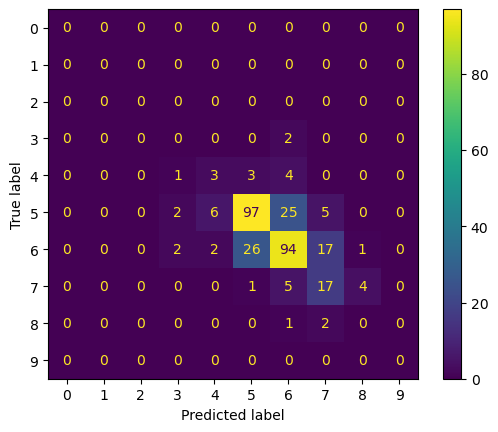

Accuracy of Decision Tree on  red2  training is:  1.0
Accuracy of Decision Tree on  red2  test data is:  0.671875


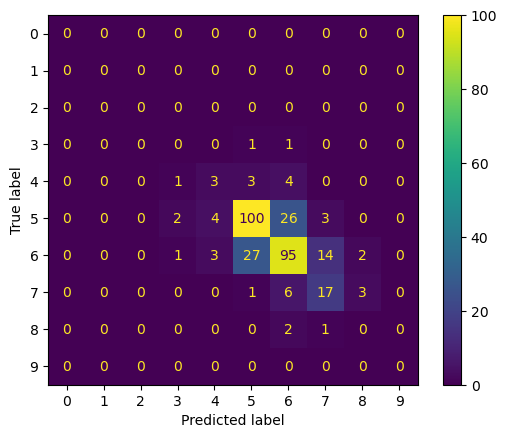

Accuracy of Decision Tree on  red3  training is:  1.0
Accuracy of Decision Tree on  red3  test data is:  0.665625


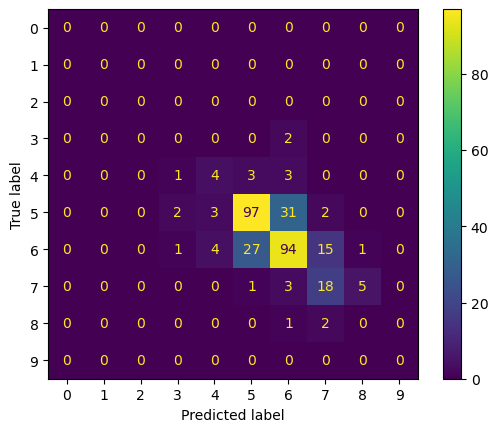

Accuracy of Decision Tree on  red4  training is:  1.0
Accuracy of Decision Tree on  red4  test data is:  0.675


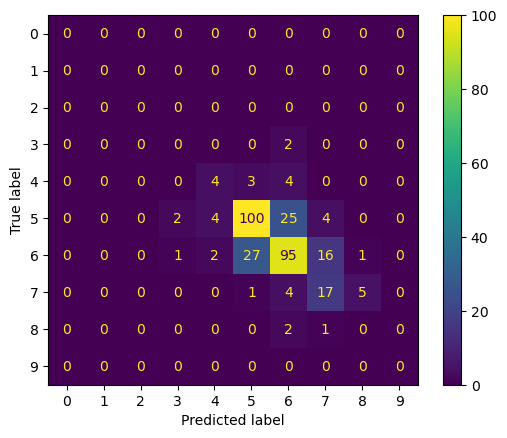

Accuracy of Decision Tree on  red5  training is:  1.0
Accuracy of Decision Tree on  red5  test data is:  0.675


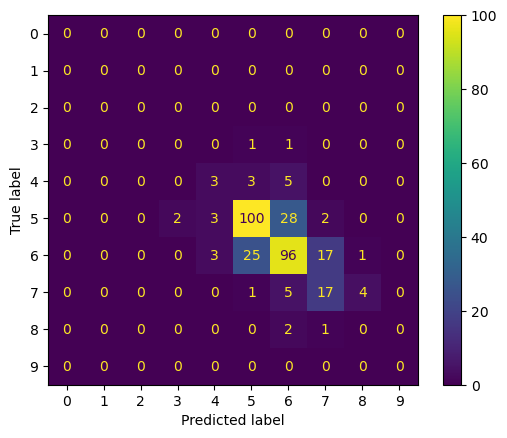

[0.659375, 0.671875, 0.665625, 0.675, 0.675]
0.6693749999999999
Accuracy of Decision Tree on  white1  training is:  1.0
Accuracy of Decision Tree on  white1  test data is:  0.5744897959183674


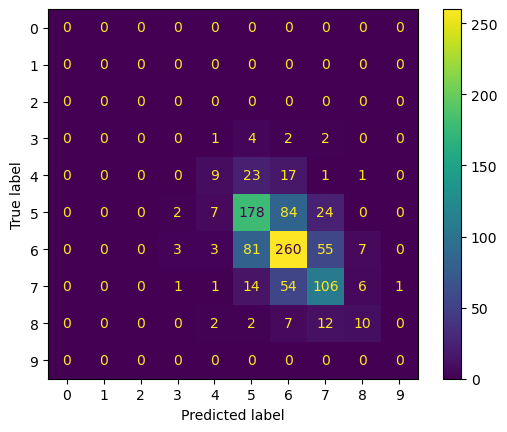

Accuracy of Decision Tree on  white2  training is:  1.0
Accuracy of Decision Tree on  white2  test data is:  0.5755102040816327


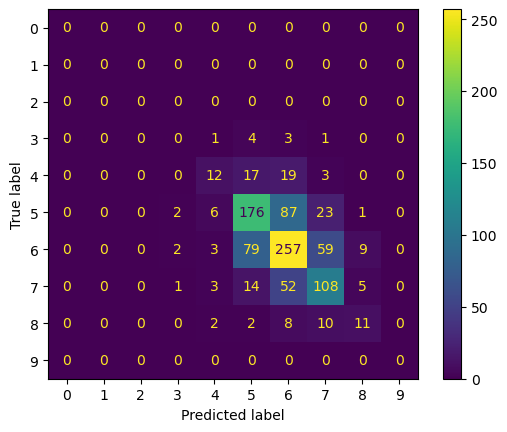

Accuracy of Decision Tree on  white3  training is:  1.0
Accuracy of Decision Tree on  white3  test data is:  0.576530612244898


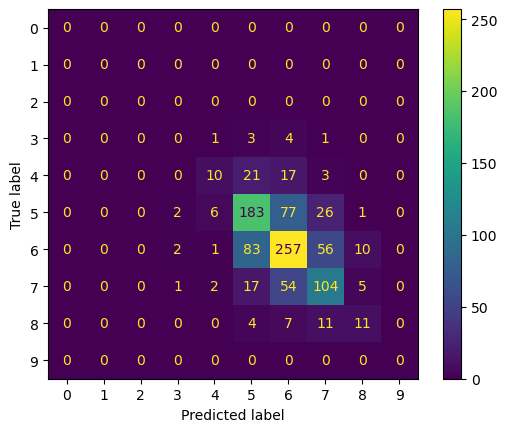

Accuracy of Decision Tree on  white4  training is:  1.0
Accuracy of Decision Tree on  white4  test data is:  0.576530612244898


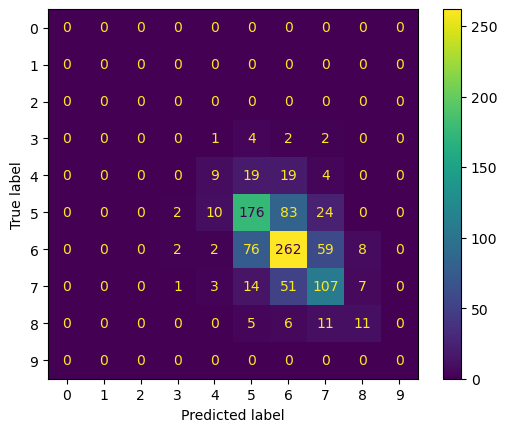

Accuracy of Decision Tree on  white5  training is:  1.0
Accuracy of Decision Tree on  white5  test data is:  0.5755102040816327


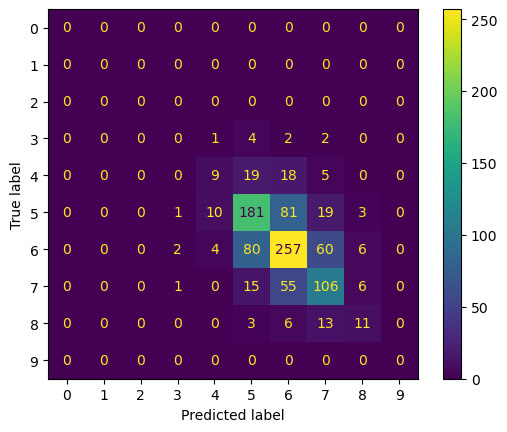

[0.5744897959183674, 0.5755102040816327, 0.576530612244898, 0.576530612244898, 0.5755102040816327]
0.5757142857142856


In [234]:
print(iterativetrain('red', 5))

print(iterativetrain('white', 5))

In [235]:
#Normalize the original data
redwinedata = redwinedataraw.copy()
whitewinedata = whitewinedataraw.copy()
whitewinelabels = whitewinedata.pop("quality")
redwinelabels = redwinedata.pop("quality")
normalizedred = normalize(redwinedata)
normalizedwhite = normalize(whitewinedata)

In [236]:
def normalizedtrain(winetype,iters): 
    accuracies=[]
    if winetype == 'white':
        data = normalizedwhite
        labels = whitewinelabels
    else:
        data = normalizedred
        labels = redwinelabels
        
    for iterations in range (iters):
        accuracies.append(trainandeval(data, labels, winetype+str(iterations+1)))
    print(accuracies)
    return sum(accuracies)/iters

Accuracy of Decision Tree on  red1  training is:  1.0
Accuracy of Decision Tree on  red1  test data is:  0.615625


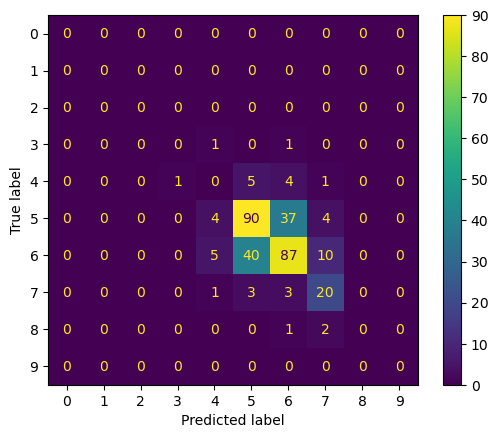

Accuracy of Decision Tree on  red2  training is:  1.0
Accuracy of Decision Tree on  red2  test data is:  0.61875


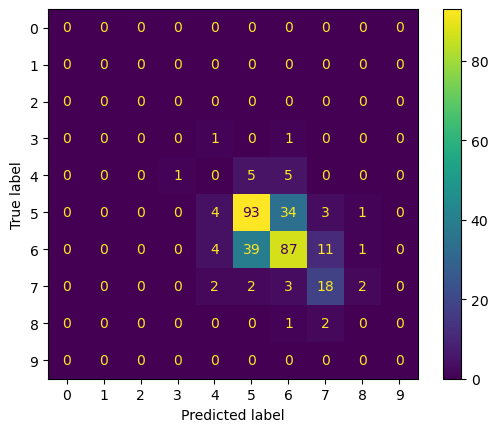

Accuracy of Decision Tree on  red3  training is:  1.0
Accuracy of Decision Tree on  red3  test data is:  0.5875


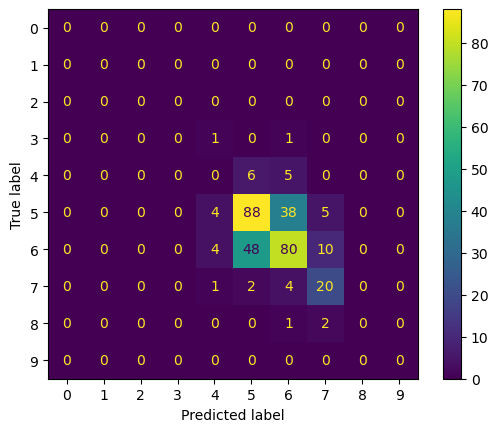

Accuracy of Decision Tree on  red4  training is:  1.0
Accuracy of Decision Tree on  red4  test data is:  0.596875


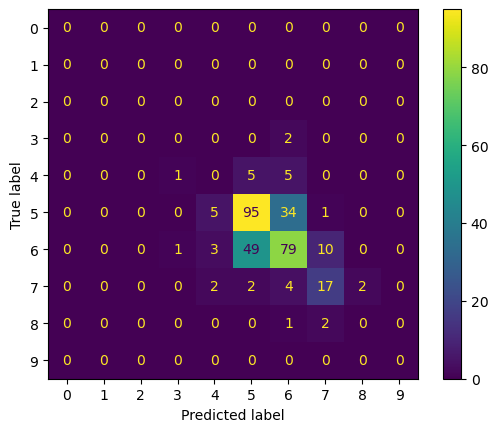

Accuracy of Decision Tree on  red5  training is:  1.0
Accuracy of Decision Tree on  red5  test data is:  0.59375


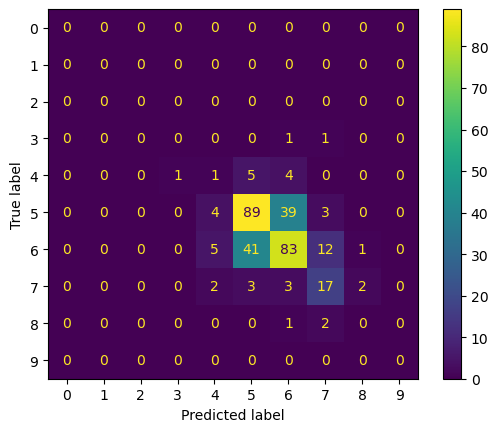

[0.615625, 0.61875, 0.5875, 0.596875, 0.59375]
0.6025
Accuracy of Decision Tree on  white1  training is:  1.0
Accuracy of Decision Tree on  white1  test data is:  0.5693877551020409


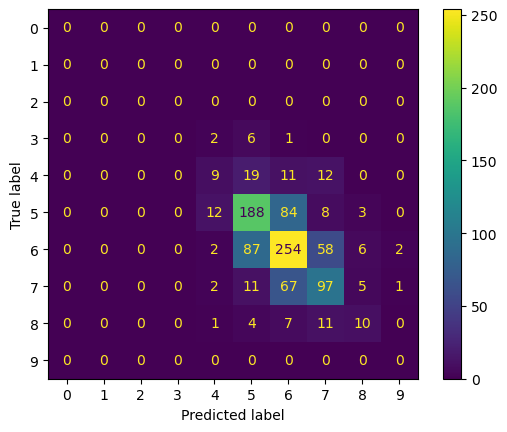

Accuracy of Decision Tree on  white2  training is:  1.0
Accuracy of Decision Tree on  white2  test data is:  0.5724489795918367


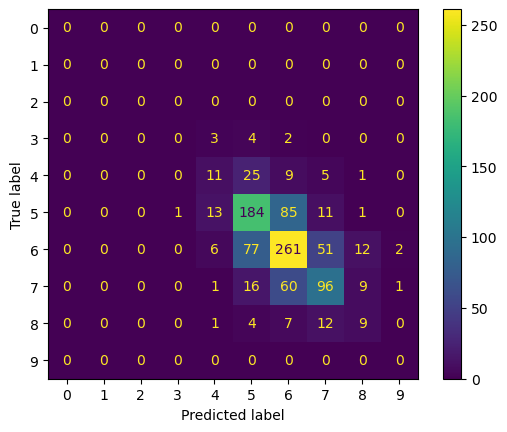

Accuracy of Decision Tree on  white3  training is:  1.0
Accuracy of Decision Tree on  white3  test data is:  0.5714285714285714


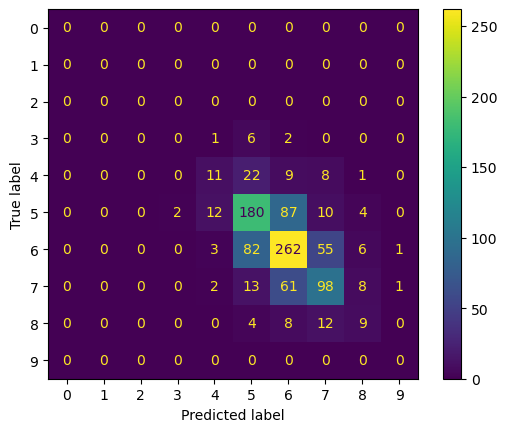

Accuracy of Decision Tree on  white4  training is:  1.0
Accuracy of Decision Tree on  white4  test data is:  0.5714285714285714


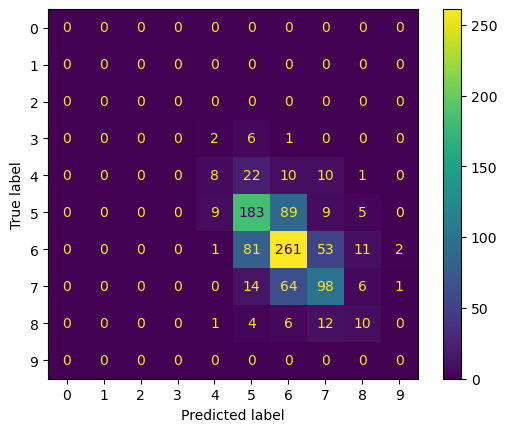

Accuracy of Decision Tree on  white5  training is:  1.0
Accuracy of Decision Tree on  white5  test data is:  0.5714285714285714


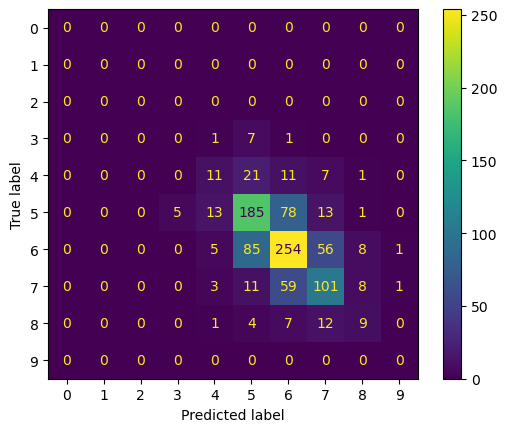

[0.5693877551020409, 0.5724489795918367, 0.5714285714285714, 0.5714285714285714, 0.5714285714285714]
0.5712244897959182


In [237]:
print(normalizedtrain('red', 5))
print(normalizedtrain('white', 5))

In [238]:
#Standardscale the original data
stdscredwinedata = redwinedataraw.copy()
stdscwhitewinedata = whitewinedataraw.copy()
whitewinelabels = stdscwhitewinedata.pop('quality')
redwinelabels = stdscredwinedata.pop('quality')
stdscred = StandardScaler().fit_transform(stdscredwinedata)
stdscwhite = StandardScaler().fit_transform(stdscwhitewinedata)



In [239]:
def stdscaletrain(winetype,iters): 
    accuracies=[]
    if winetype == 'white':
        data = stdscwhite
        labels = whitewinelabels
    else:
        data = stdscred
        labels = redwinelabels
        
    for iterations in range (iters):
        accuracies.append(trainandeval(data, labels, winetype+str(iterations+1)))
    print(accuracies)
    return sum(accuracies)/iters

Accuracy of Decision Tree on  red1  training is:  1.0
Accuracy of Decision Tree on  red1  test data is:  0.69375


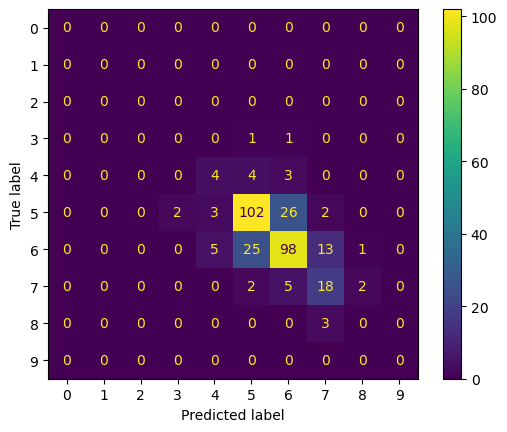

Accuracy of Decision Tree on  red2  training is:  1.0
Accuracy of Decision Tree on  red2  test data is:  0.68125


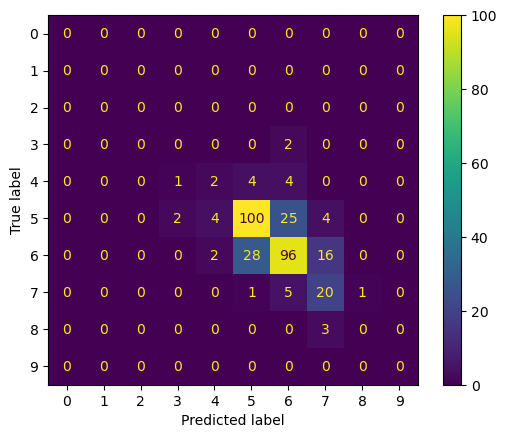

Accuracy of Decision Tree on  red3  training is:  1.0
Accuracy of Decision Tree on  red3  test data is:  0.675


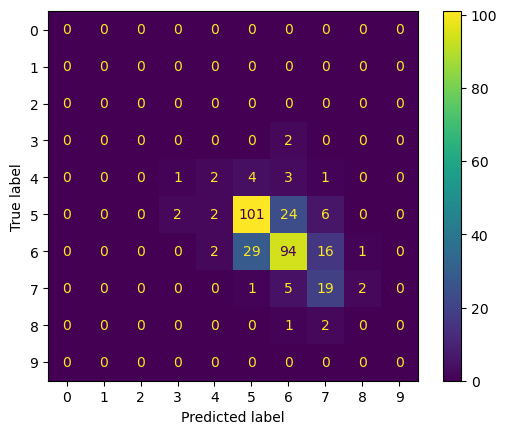

Accuracy of Decision Tree on  red4  training is:  1.0
Accuracy of Decision Tree on  red4  test data is:  0.684375


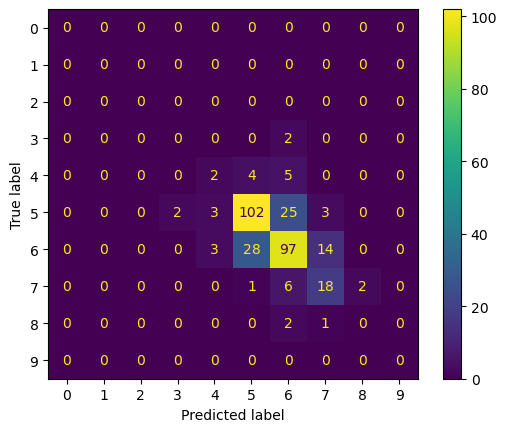

Accuracy of Decision Tree on  red5  training is:  1.0
Accuracy of Decision Tree on  red5  test data is:  0.68125


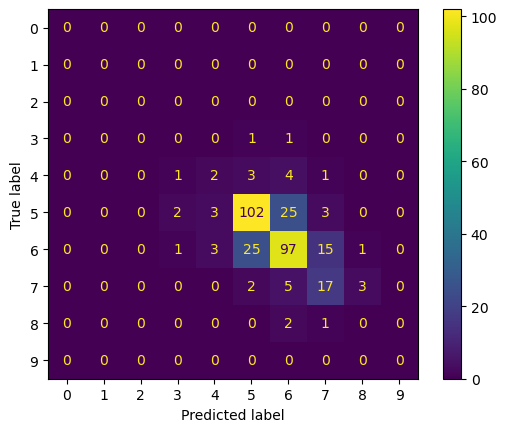

[0.69375, 0.68125, 0.675, 0.684375, 0.68125]
0.683125
Accuracy of Decision Tree on  white1  training is:  1.0
Accuracy of Decision Tree on  white1  test data is:  0.5724489795918367


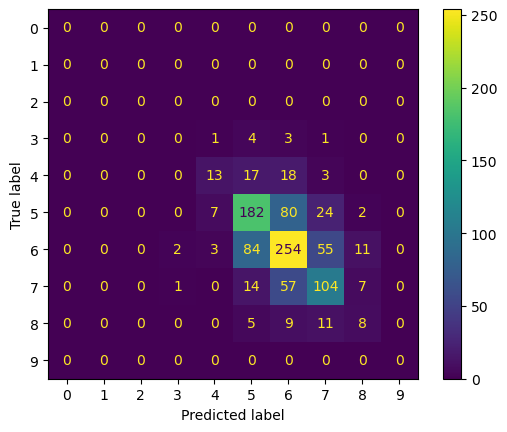

Accuracy of Decision Tree on  white2  training is:  1.0
Accuracy of Decision Tree on  white2  test data is:  0.5887755102040816


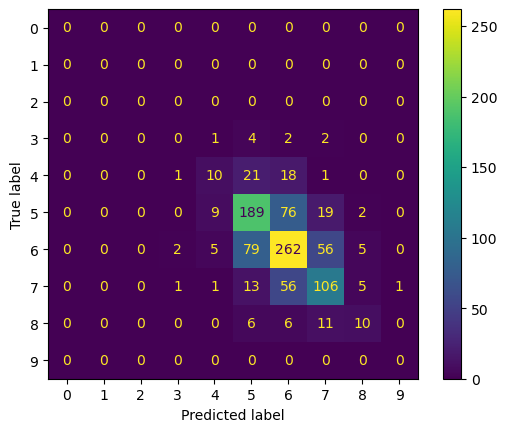

Accuracy of Decision Tree on  white3  training is:  1.0
Accuracy of Decision Tree on  white3  test data is:  0.5846938775510204


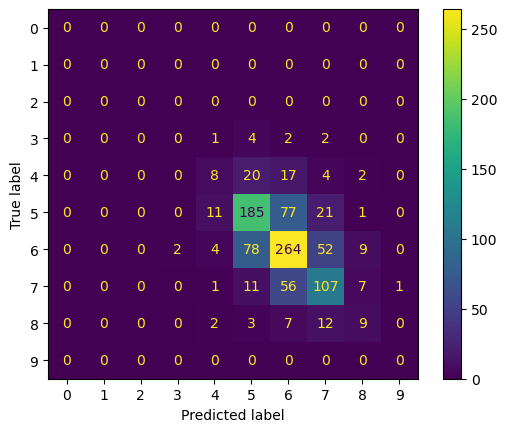

Accuracy of Decision Tree on  white4  training is:  1.0
Accuracy of Decision Tree on  white4  test data is:  0.5918367346938775


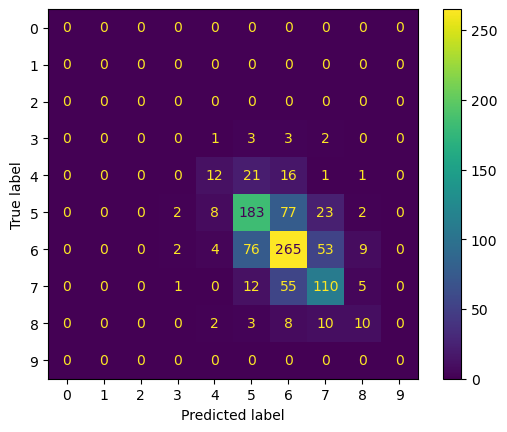

Accuracy of Decision Tree on  white5  training is:  1.0
Accuracy of Decision Tree on  white5  test data is:  0.5806122448979592


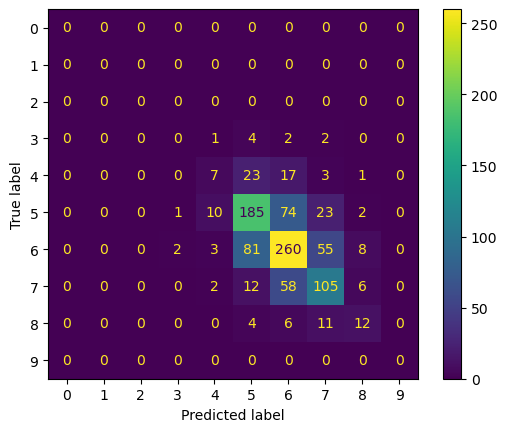

[0.5724489795918367, 0.5887755102040816, 0.5846938775510204, 0.5918367346938775, 0.5806122448979592]
0.5836734693877551


In [240]:
print(stdscaletrain('red', 5))

print(stdscaletrain('white', 5))